In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *
from tqdm import tqdm_notebook
from scipy.constants import h, hbar, k as kb

In [3]:
from itertools import product
from scipy import optimize
from importlib import reload

In [4]:
from ReadoutResonator import *

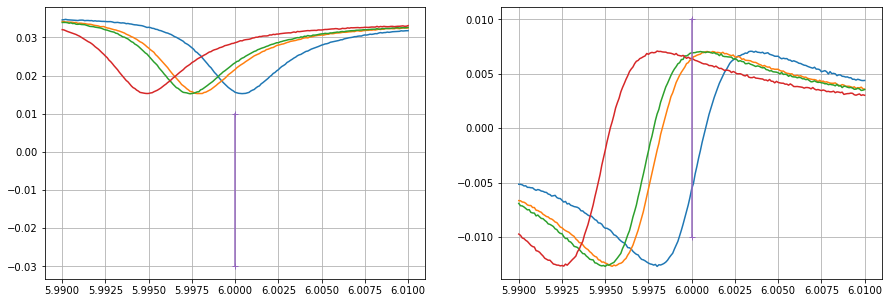

In [5]:
r = ReadoutResonator(6, 1118, 1964, phi=0.29)
r.set_qubit_parameters(.05, 0.05, 5, 5.3, .2, .2)
chi1, chi2 = .25e-3*10, .3e-3*10
plt.subplot(1,2,1)
r.plot()
r.plot(chi1)
r.plot(chi2)
r.plot(chi1+chi2)
plot([6.000]*2, [-0.03, 0.01], "-+")
grid()
plt.subplot(1,2,2)
r.plot(digest = np.imag)
r.plot(chi1, digest = np.imag)
r.plot(chi2, digest = np.imag)
r.plot(chi1+chi2, digest = np.imag)
plot([6.000]*2, [-0.01, 0.01], "-+")
grid()
plt.gcf().set_size_inches(15,5)

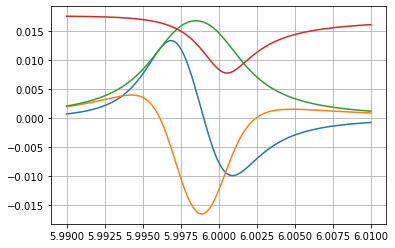

In [6]:
freqs = linspace(5.99, 6.01, 1000)
r.set_noise_sigma(0)
plot(freqs, real(r.S_param(freqs, 0) - r.S_param(freqs, chi2)))
plot(freqs, imag(r.S_param(freqs, 0) - r.S_param(freqs, chi2)))
plot(freqs, abs(r.S_param(freqs, 0) - r.S_param(freqs, chi2)))
plot(freqs, abs(r.S_param(freqs, 0))/2)
plt.grid()

In [7]:
import single_transmon.Transmon
reload(single_transmon.Transmon)
from single_transmon.Transmon import *

In [8]:
Nc = 7
Ec1 = 0.25 * 2 * np.pi
Ec2 = Ec1
Ecc = 0.010/1.2**2 * 2 * np.pi # 1.2 is my estimate for n_{ge} matrix element
Ej1 = Ec1 * 100
Ej2 = Ec2 * 100
d = 0.75

T1_1, T2_1 = 10e3, 5e3
T1_2, T2_2 = 5e3, 1e3

tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, 3, 1)
tr2 = Transmon(Ec2, Ej2, d, 1/T1_2, 1/T2_2, Nc, 3, 2)

In [9]:
import two_transmons.TransmonControl
reload(two_transmons.TransmonControl)
from two_transmons.TransmonControl import *

In [10]:
TC = TransmonControl(tr1)

In [11]:
result = TC.run()

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.17s. Est. time left: 00:00:00:00
30.0%. Run time:   0.31s. Est. time left: 00:00:00:00
40.0%. Run time:   0.37s. Est. time left: 00:00:00:00
50.0%. Run time:   0.44s. Est. time left: 00:00:00:00
60.0%. Run time:   0.50s. Est. time left: 00:00:00:00
70.0%. Run time:   0.56s. Est. time left: 00:00:00:00
80.0%. Run time:   0.64s. Est. time left: 00:00:00:00
90.0%. Run time:   0.73s. Est. time left: 00:00:00:00
Total run time:   0.79s


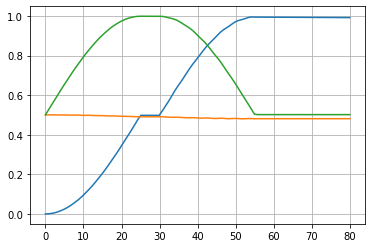

In [12]:
TC.visualize_dynamics()

In [13]:
import two_transmons.DoubleTransmonSystem
reload(two_transmons.DoubleTransmonSystem)
from two_transmons.DoubleTransmonSystem import *

In [14]:
import two_transmons.ZPulse
reload(two_transmons.ZPulse)
from two_transmons.ZPulse import *

In [32]:
dts = DoubleTransmonSystem(tr1, tr2, Ecc)

In [16]:
expect(r.measurement_operator(6, array(r.get_dipsersive_shifts())), dts.e_state(1/2, 1/2, 2))

<ipython-input-16-cabc6e71618b>:1: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  expect(r.measurement_operator(6, array(r.get_dipsersive_shifts())), dts.e_state(1/2, 1/2, 2))


TypeError: Arguments must be quantum objects or eseries

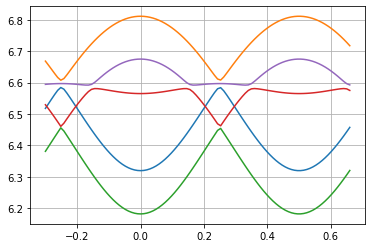

In [18]:
phi1s = linspace(-0.3, .66, 100)
phi2s = phi1s + 0.5  # 1/2*ones_like(phi1s)

dts.plot_spectrum(phi1s, phi2s)
# plt.xlim(0.3,0.4)

In [19]:
tr1.ge_freq_approx(1/2), tr2.ge_freq_approx(1/2)

(6.338641496869068, 6.338641496869068)

In [20]:
 ###dts.H(0.63875, 1/2).eigenstates()[1][1]

## VRS

In [21]:
import two_transmons.VacuumRabiSimulation
reload(two_transmons.VacuumRabiSimulation)
from two_transmons.VacuumRabiSimulation import *

In [22]:
params = {
    'duration': 18.25*100,
    'tanh_sigma': 1.17,
    "start": 10,
    "finish": 200,
    "phi_base_level": 1/2,
    'phi_offset': -0.3843,
}

Ts = linspace(0, params["finish"], 2*params["finish"]+1)

VRS = VacuumRabiSimulation(dts, Ts, params, r)

In [26]:
evals, evecs = dts.H(params["phi_base_level"]+params["phi_offset"], 1/2).eigenstates()

In [30]:
print (dts.e_state(1/2, 1/2, 1))

None


In [24]:
(evecs[1].dag()*dts.e_state(1/2, 1/2, 1)), sqrt(2)/2

TypeError: unsupported operand type(s) for *: 'Qobj' and 'NoneType'

In [25]:
result = VRS.run()

KeyError: 'frequency'

In [ ]:
r.set_noise_sigma(0e-5)

In [ ]:
VRS.visualize_joint_readout(6)

In [ ]:
dts.plot_per_qubit_xyz_dynamics(1/2, 1/2, Ts, VRS._result.states)

## CPHASE

In [ ]:
class RamseySimulation:
    
    def __init__(self, dts, Ts):
        self._dts = dts
        self._Ts = Ts
        self._params = params
        self._rho0_control_off = ket2dm(1/sqrt(2)*(dts.gg_state(1/2, 1/2) + 1j*dts.e_state(1/2, 1/2, 1)))
        self._rho0_control_on = ket2dm(1/sqrt(2)*(dts.e_state(1/2, 1/2, 2) + 1j*dts.ee_state(1/2, 1/2)))
        
        self._c_ops = dts.c_ops(1/2, 1/2)
        
    def run(self):
        options = Options(nsteps=10000)
        self._result_off = mesolve(dts.H(1/2,1/2), self._rho0_control_off, self._Ts, c_ops = self._c_ops, 
                                   progress_bar=True, options=options)
        self._result_on = mesolve(dts.H(1/2, 1/2), self._rho0_control_on, self._Ts, c_ops = self._c_ops, 
                                  progress_bar=True, options=options)
        
        return self._result_on, self._result_off

In [ ]:
Ts = linspace(0, 2000, 400)

RS = RamseySimulation(dts, Ts)

In [ ]:
RS.run()

In [ ]:
sx = projection(3, 0, 1) + projection(3, 1, 0)
U_rot = tensor((1j*sx*pi/4).expm(), identity(tr2.get_Ns()))
# (RS._rho0_control_on.tidyup(atol=1e-3))
(U_rot*RS._rho0_control_off*U_rot.dag()).tidyup(atol=1e-3)

In [ ]:
ramsey_on = []
ramsey_off = []

for t, state_off, state_on in zip(Ts, RS._result_off.states, RS._result_on.states):
    print("\r", t, end = "", flush = True)
    U1 = tr1.H_diag_trunc_approx(1/2)-projection(3, 1,1)*2*pi*5e-3 - projection(3, 2, 2)*2*pi*10e-3
    U2 = tr2.H_diag_trunc_approx(1/2)-projection(3, 1,1)*2*pi*5e-3 - projection(3, 2, 2)*2*pi*10e-3
    
    U = (1j*t*tensor(U1, identity(tr2.get_Ns())) + 
         1j*t*tensor(identity(tr1.get_Ns()), U2)).expm()
    
    sx = projection(3, 0, 1) + projection(3, 1, 0)
    U_rot = tensor((-1j*sx*pi/4).expm(), identity(tr2.get_Ns()))           
    
    ramsey_on.append(expect(U_rot.dag()*U*state_on*U.dag()*U_rot, r.measurement_operator(6.0015, r.get_dipsersive_shifts())))
    ramsey_off.append(expect(U_rot*U*state_off*U.dag()*U_rot.dag(), r.measurement_operator(6.0015, r.get_dipsersive_shifts())))

In [ ]:
evals = dts.H(1/2,1/2).eigenenergies()
evals = (evals - evals[0])/2/pi
evals

In [ ]:
tr1.ge_freq_approx(1/2) - evals[1],\
tr1.ge_freq_approx(1/2) - (evals[5]-evals[2])

In [ ]:
1/0.00207

In [ ]:
expect(r.measurement_operator(6.0015, chi1, chi2), dts.e_state(1/2, 1/2, 2))
expect(r.measurement_operator(6.0015, chi1, chi2), dts.ee_state(1/2, 1/2))

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(Ts, array(ramsey_off).real)
axes[1].plot(Ts, array(ramsey_off).imag, "C1")
fig, axes = plt.subplots(2, 1)
axes[0].plot(Ts, array(ramsey_on).real)
axes[1].plot(Ts, array(ramsey_on).imag, "C1")

In [ ]:
plot(Ts, np.abs(ramsey_off))
plot(Ts, np.abs(ramsey_on))
plt.grid()

In [ ]:
tr1.H_diag_trunc_approx(1/2)-projection(3, 1,1)*2*pi*5e-3 - projection(3, 2, 2)*2*pi*10e-3

In [ ]:
Us = [(-1j*t*self._tr.H_diag_trunc_approx(1/2)).expm() for t in self._Ts]


In [ ]:
RS._result_on.states[0]

In [ ]:
phi1s = linspace(-0.3, .66, 100)
phi2s = 1/2*ones_like(phi1s)

dts.plot_spectrum(phi1s, phi2s)
# plt.xlim(0.3,0.4)

In [ ]:
class CPhaseSimulation:
    
    def __init__(self, dts, Ts, params):
        self._dts = dts
        self._Ts = Ts
        self._params = params
        
        self._rho0_control_off = 1/sqrt(2)*(dts.gg_state(1/2, 1/2) + dts.e_state(1/2, 1/2, 1))
        self._rho0_control_on = 1/sqrt(2)*(dts.e_state(1/2, 1/2, 2) + dts.ee_state(1/2, 1/2))
        
    def build_waveforms(self):
        waveform1 = waveform2 = ones_like(Ts)*1/2
        return waveform1, waveform2
    
    def run(self):
        options = Options(nsteps=10000)
        self._result_off = mesolve(dts.H(0,1/2), self._rho0_control_off, 
                                   self._Ts, c_ops = self._dts.c_ops(1/2, 1/2),
                                   progress_bar=True, options=options)
        self._result_on = mesolve(dts.H(0, 1/2), self._rho0_control_on, 
                                  self._Ts, c_ops = self._dts.c_ops(1/2, 1/2),
                                  progress_bar=True, options=options)
        
        return self._result_off, self._result_on


In [ ]:
params = {
    "finish": 100
}

Ts = linspace(0, params["finish"], params["finish"]+1)

CPS = CPhaseSimulation(dts, Ts, params)

In [ ]:
result_off, result_on = CPS.run()

In [ ]:
angles_off = array([angle(state[0,3]) for state in result_off.states])
angles_on = array([angle(state[1,4]) for state in result_on.states])

In [ ]:
plot(unwrap(angles_off-angles_on))

## Tomography

### Rabi

In [ ]:
from two_transmons import Rabi
reload(two_transmons.Rabi)
from two_transmons.Rabi import *

In [ ]:
Ts = linspace(0, 1000, 200)
R = Rabi(dts, Ts, 1, r)
R.run()

In [ ]:
R.visualize_joint_readout(6, chi1, chi2)

### Tomo

In [ ]:
from two_transmons import Tomography
reload(two_transmons.Tomography)
from two_transmons.Tomography import *

In [ ]:
params = {
    'duration': 18.25,
    'tanh_sigma': 1,
    "start": 10,
    "finish": 260,
    "phi_base_level": 1/2,
    'phi_offset': -0.3843,
}

Ts = linspace(0, params["finish"], 2*params["finish"]+1)

T = Tomography(dts, Ts, params, r)

In [ ]:
T.run()

In [ ]:
r.set_noise_sigma(0)

In [ ]:
T.visualize_joint_readout(6.001, chi1, chi2)

In [ ]:
dts.plot_per_qubit_xyz_dynamics(1/2, 1/2, Ts, [(s) for s in T._results[-9].states])

In [ ]:
labels = ["|"+"".join(pair)+r"$\rangle$" for pair in list(product(*[["0", "1", "2"]]*2))]

In [ ]:
time_idx = 60
visualization.matrix_histogram_complex(T._results[-7].states[time_idx], xlabels=labels, ylabels = labels, limits = (0,0.5))
plt.gcf().set_size_inches(15,10)
plt.title(Ts[time_idx])

In [ ]:
expects = []
r.set_noise_sigma(4e-4)

for i in range(len(T._q1_rotations)):
    row = []
    for j in range(len(T._q1_rotations)):
        state = T._results[i*len(T._q1_rotations)+j].states[-1]
        row.append((expect(r.measurement_operator(6.001, chi1, chi2), state)))
    expects.append(row)

In [ ]:
ops = ["+I", "+X/2", "+Y/2", "-X/2", "-Y/2", "+X", "+Y"]

In [ ]:
fig, axes = plt.subplots(1, 2)
m1 = axes[0].imshow(real(expects))
m2 = axes[1].imshow(imag(expects))
for ax, m in zip(axes, [m1, m2]):
    ax.set_xticks(range(7))
    ax.set_yticks(range(7))

    ax.set_xticklabels(ops)
    ax.set_yticklabels(ops)
    plt.colorbar(m, ax=ax, shrink=0.6)
plt.gcf().set_size_inches(15,10)

In [ ]:
def x_to_rho(x):                                # Density matrix parametrization via Choletsky decomposition
    dim = int(sqrt(len(x)))
    t = np.identity(dim, complex)
    for i in range(dim):
        t[i, i] = abs(x[i])
    k = dim
    for i in range(dim):
        for l in range(i + 1, dim):
            t[i, l] = x[k] + 1j * x[k + 1]
            k += 2
    q_dim = [2] * int(log(dim) / log(2))
    rho = Qobj(t, dims=[q_dim, q_dim])
    rho = rho.dag() * rho
    rho = rho / rho.tr()
    return rho

def rho_to_x(rho):
    if rho is None:
        return None
    ps_rho = rho + 1e-12                                            # wtf KOSTYL'
    L_ar = (Qobj(cholesky(ps_rho.full())).dag()).full()             # dont touch
    L_dim = L_ar.shape[0]
    x = np.zeros(L_dim ** 2, dtype=np.complex)
    k = L_dim
    for i in range(L_dim):
        x[i] = L_ar[i, i]
        for j in range(i + 1, L_dim):
            x[k] = real(L_ar[i, j])
            x[k + 1] = imag(L_ar[i, j])
            k += 2
    return x

def rotator_from_command(com):
    axes = {'I': identity(2), 'X': sigmax(), 'Y': sigmay(), 'Z': sigmaz()}
    ax = axes[com[1]]
    amp = eval(com[0] + '1' + com[2:])
    return (-1j * amp * pi / 2 * ax).expm()

def rotation_sequence_from_command_list(com_list):
    rot_seq = []
    for coms in com_list:
        op = tensor(list(map(rotator_from_command, coms)))
        rot_seq.append(op)
    return rot_seq
    
def likelihood(x):                        # Вычисление Likelihood по загруженным измерениям \
    rho = x_to_rho(x)                      # для матрицы плотности заданной через x
    lh = 0
    for (op, ex) in measurements:
        lh += abs(expect(rho, op) - ex) ** 2
    return lh

In [ ]:
command_list = list(product(*[["+I", "+X/2", "+Y/2", "-X/2", "-Y/2", "+X", "+Y"]]*2))
local_rotations = rotation_sequence_from_command_list(command_list)
r.set_noise_sigma(0)
measurements = [(rot.dag() * r.measurement_operator(6.001, chi1, chi2, 2) * rot, res)
                                for (rot, res) in zip(local_rotations, array(expects).ravel())]

In [17]:
phase_rotator = tensor((-1j/2*sigmaz()*-0.64*pi).expm(), identity(2))
theory = ket2dm(phase_rotator*sqrtiswap()*tensor(basis(2,1), basis(2,1)))
theory

<ipython-input-17-989cb352d2ba>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  theory = ket2dm(phase_rotator*sqrtiswap()*tensor(basis(2,1), basis(2,1)))


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

In [ ]:
arctan2(213, 452)/pi

In [ ]:
for n in tqdm_notebook(range(5), desc='Tomography: Likelihood minimization', ncols=700):
    x0 = real(rho_to_x(theory)) + random.normal(scale=0.2)
    new = optimize.minimize(likelihood, x0, method='Nelder-Mead')
    if n == 0:
        best = new
    else:
        if new.fun < best.fun:
            best = new
print(best.fun)
x_to_rho(best.x)

In [ ]:
arctan2(-0.5, 0)/pi

In [ ]:
arctan2(0.182, .369)/pi

In [ ]:
phase_rotator.dag()*theory*phase_rotator

In [ ]:
r.set_noise_sigma(0e-4)

measurements_theory = reshape([expect(rot.dag() * r.measurement_operator(6.001, chi1, chi2, 2) * rot, 
                                      theory)
                                for rot in local_rotations], (int(sqrt(len(local_rotations))), -1))
measurements_fit = reshape([expect(rot.dag() * r.measurement_operator(6.001, chi1, chi2, 2) * rot, 
#                                    phase_rotator.dag()*x_to_rho(best.x)*phase_rotator)
                                   x_to_rho(best.x))
                                   for rot in local_rotations], (int(sqrt(len(local_rotations))), -1))

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(15,8))

data = [expects, measurements_fit, measurements_theory]
digest = [real, imag]
titles = list(product(["$\mathcal{Re}\ S_{21}$", "$\mathcal{Im}\ S_{21}$"], ["experiment", "fit", "ideal"]))

i=0
for row, digest in zip(axes, digest):
    for ax, datum in zip(row, data):
        m = ax.imshow(digest(datum))
        ax.set_xticks(range(7))
        ax.set_yticks(range(7))
        ax.set_xticklabels(ops)
        ax.set_yticklabels(ops)
        ax.set_title(", ".join(titles[i])); i+=1
        plt.colorbar(m, ax=ax, shrink=0.7)
# plt.savefig("sqrtiswap_proto/measurements_from_11.png", bbox_inches="tight", dpi=300)

In [ ]:
(x_to_rho(best.x)**2).tr()

In [ ]:
fidelity(x_to_rho(best.x), theory)

In [ ]:
labels = ["|"+"".join(pair)+r"$\rangle$" for pair in list(product(*[["0", "1"]]*2))]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
visualization.matrix_histogram_complex(x_to_rho(best.x), ax=ax)
ax.set_title("Experiment")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("Ideal")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

visualization.matrix_histogram_complex(theory, ax= ax)
# plt.savefig("sqrtiswap_proto/sqrtiwap-from-11.png", dpi=300, bbox_inches="tight")